<h1>Time Series analysis of U.S.A. retail fuel prices <h1>
<h3>Before running the analysis itself, the 314 observations from the dataset (corresponding to 314 months, or aproximatively 24 years) into a training subset (first 80% of the total observations) and a testing subset (remaining 20%) for the models employed. <h3> <br>
Firstly we shall draw a line chart of the evolution of the fuel prices while highlighting the size of the subsets. </br>

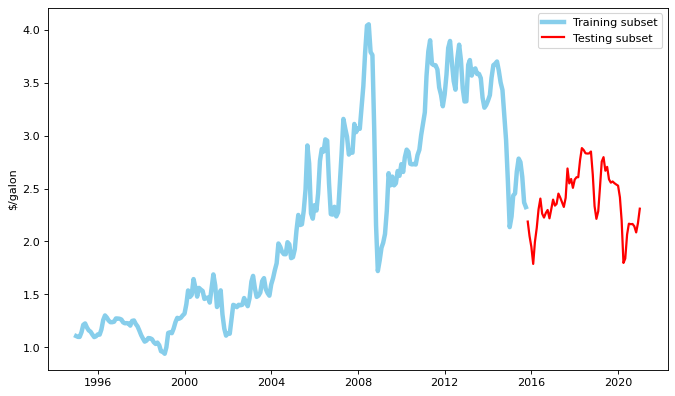

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot
from matplotlib.pyplot import figure


from sklearn.model_selection import train_test_split
path = "\Data\PET_PRI_GND_DCUS_NUS_W.csv" #input path to data
df = pd.read_csv(path)
df["Oprice"] = pd.to_numeric(df.Oprice, errors = 'coerce')
df["DATE"] = pd.to_datetime(df['DATE'])
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
figure(figsize=(10, 6), dpi=80)
pyplot.plot( 'DATE', "Oprice", data=X_train, marker='', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=4)
pyplot.plot( 'DATE', 'Oprice', data=X_test, marker='', color='red', linewidth=2)
#pyplot.fill_between(X_test['DATE'],X_test['upper'], X_test['lower'], color='k', alpha=0.3, label = 'Confidence Interval')
pyplot.ylabel("$/galon")
pyplot.legend(["Training subset", "Testing subset"], loc ="upper right")

# show legend


# show graph
pyplot.show()


In [2]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf

#Function that calculates a series of accuracy indicators for our model
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-actual)[1]                      # ACF1

    print("MAPE: {mape} \n ME: {me} \n MAE: {mae} \n MPE: {mpe} \n RMSE: {rmse}".format(mape = mape, me=me, mae=mae, mpe=mpe, rmse=rmse) )


<h3>Based on the chart we can see that this time series has both trend and seasonality. We can also determine that the series is non-stationary in its mean and not in its variance.<h3>
<blockquote>We shall draw the autocorrelation and partial autocorrelation charts in order to properly determine if the series is indeed non-stationary.<blockquote>

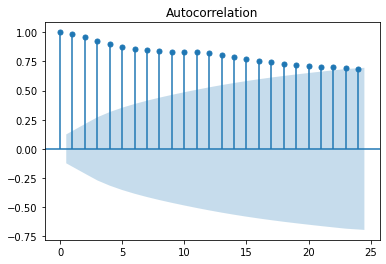

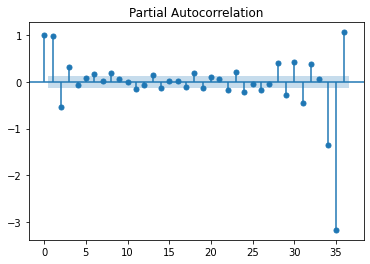

In [3]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(X_train["Oprice"])
plot_pacf(X_train["Oprice"], lags=36)
pyplot.show()

<h3> From the autocorrelation chart we can see that the series is truly non-stationary, the autocorrelation coefficient slowly decreasing. <h3>
<blockquote>In order to obtain a better outlook on the series's non-stationarity, we shall apply the Augmented Dickey-Fuller test upon it. <blockquote>

In [4]:
from statsmodels.tsa.stattools import adfuller

X= X_train["Oprice"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.373207
p-value: 0.595051
Critical values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


<h2>The results obtained from the Augmented Dickey-FUller test indicate a p-value of 0.59, thus meaning that we cannot reject the null hypothesis which states that the fuel price series is non-stationary. <h2>

<h3> As the series is non-stationary, in order to perform relevant statistical analyses on it, the series must be first degree differentiated.  

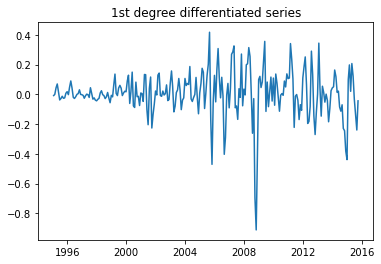

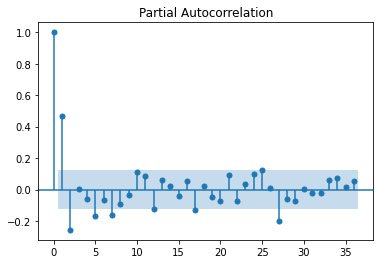

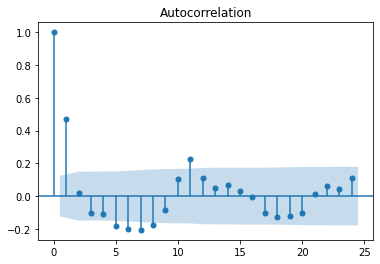

In [5]:
diff=X_train["Oprice"].diff()

pyplot.plot(X_train['DATE'],diff)
pyplot.title("1st degree differentiated series")
pyplot.show()
Y = diff.dropna()


plot_pacf(Y, lags=36)
plot_acf(Y)
pyplot.show()

<h3>We can observe based on the line chart of the differentiated series that the trend has disappeared, thus the series becoming stationary. In order to confirm this change, we shall check the autocorrelation chart. By analyzing it, we can see that the series is indeed stationary, the autocorrelation coefficient decreasing abruptly after the second lag.<br> We can also spot the series seasonality on the autocorrelation chart. .<h3>
<blockquote>In order to obtain a definitive answer on this series stationarity, we shall use the Augmented Dickey-Fuller test upon it once more.<blockquote>

In [6]:
result2 = adfuller(Y)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Valori critice:')
for key, value in result2[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.088236
p-value: 0.000000
Valori critice:
	1%: -3.458
	5%: -2.874
	10%: -2.573


<h3> The Augmented Dickey-Fuller test has a p-value of 0, thus indicating that the null hypothesis can be rejected in favor of the alternative hypothesis. In other words, the test's result shows that the series is clearly stationary. <h3>
<blockquote> In order to find the optimal model, the series will be 2nd degree differentiated. <blockquote>

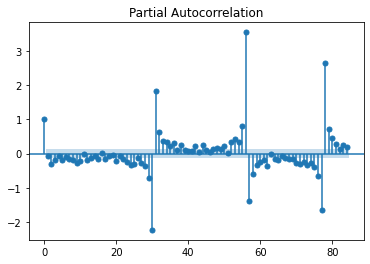

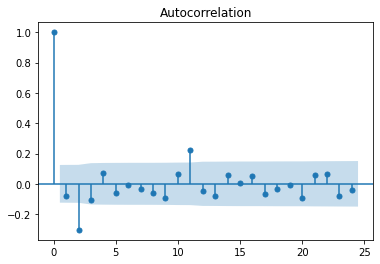

ADF Statistic: -8.088236
p-value: 0.000000
Critical values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [7]:
diff2 = Y.diff()
Z=diff2.dropna()
result3 = adfuller(Y)
plot_pacf(Z, lags=84)
plot_acf(Z)

pyplot.show()
print('ADF Statistic: %f' % result3[0])
print('p-value: %f' % result3[1])
print('Critical values:')
for key, value in result3[4].items():
	print('\t%s: %.3f' % (key, value))

<h3> We see based on the charts and on the Augmented Dickey-Fuller test's results that the series is stationary and that it can be used in a potential SARIMA model.<h3>

<h2>SARIMA <h2>
<h3> Firstly we will take a look at the SARIMA models using the 1st degree differentiation <h3>
<blockquote> The first model is SARIMA(1,1,1)x(1,1,1,12), as the dataset has a monthly frequency <blockquote>

                                     SARIMAX Results                                      
Dep. Variable:                             Oprice   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 141.572
Date:                            Mon, 16 Aug 2021   AIC                           -271.143
Time:                                    11:36:21   BIC                           -250.335
Sample:                                         0   HQIC                          -262.756
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0008      0.002     -0.410      0.682      -0.004       0.003
ar.L1          0.0911      0.120   

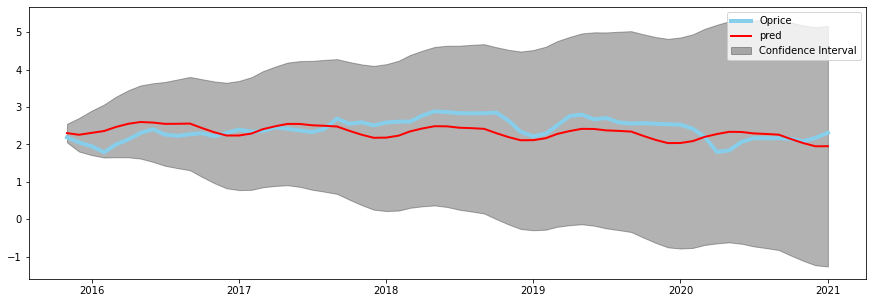

In [8]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson

model = SARIMAX(X_train['Oprice'], order=(1,1,1), seasonal_order=(1,1,1,12), trend='c') #Defining SARIMA model parameters
model_fit = model.fit()
#df['forecast'] = model_fit.predict(exog =1,typ='levels')
print(model_fit.summary())

print("Durbin-Watson test result: ",durbin_watson(model_fit.resid)) #Durbin-Watson

ax = pyplot.subplots(figsize=(15, 5))
fcast = model_fit.get_forecast(steps = 70).summary_frame() # Generating point prediction and confidence interval values for each prediction
X_test['pred'] = fcast['mean']
X_test['lower'] = fcast['mean_ci_lower']
X_test['upper'] = fcast['mean_ci_upper']


A = np.identity(len(model_fit.params))
A=A[1:,:]
Fvalue = model_fit.f_test(A) #F test
print("The F test value: ",Fvalue)

#print(X_test)
#pyplot.plot( 'DATE', "Oprice", data=X_train, marker='', markerfacecolor='green', markersize=10, color='green', linewidth=4)
pyplot.plot( 'DATE', "Oprice", data=X_test, marker='', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=4)
pyplot.plot( 'DATE', 'pred', data=X_test, marker='', color='red', linewidth=2)
pyplot.fill_between(X_test['DATE'],X_test['upper'], X_test['lower'], color='k', alpha=0.3, label = 'Confidence Interval')


# Show legend
pyplot.legend()

# Show chart
pyplot.show()

On the basis of the SARIMA model's output, the only relevant model components are the mobile averages: ma.L1 și ma.S.L12 and $sigma^2$, despite all of this, the Ljung Box-Test has a p-value of 0.92, thus leading us to accept the null hypothesis which states that the data is not simply white noise, and that it can be properly modeled. <br> The Durbin-Watson test has a p-value of 1.76, indicating a slight positive autocorrelation, while the F test value shows that the model is valid. <br>
The next 63 months have been predicted in order to compare the model's results to the testing subset in order to better gauge the model's effectiveness. We see that the predicted values are largely close to the testing subset, but it is clear that after the first 8 months (June 2016) the predictions become unreliable as the prediction interval becomes to large. <br>
<br>
The informational criteria report the following values: Akaike - AIC (-271.143), Schwarz - BIC (-250.335) and Hannan - HQIC (-262.756). 



In [9]:
#print(X_test)
forecast_accuracy(X_test['pred'], X_test['Oprice'])

Residuals = []
for index, row in X_test.iterrows():
    Residuals.append(row['pred']-row['Oprice'])
    
Reziduals = pd.Series(Residuals, name = "Residuals")

MAPE: 0.11215546783592871 
 ME: -0.07838792365989296 
 MAE: 0.2678716404090553 
 MPE: -0.02057678500547852 
 RMSE: 0.3057007889052186


We can see that the MAPE value is 0.11%, which means that the average prediction error is around 0.11% of the real values. <br>
The RMSE value shows that the mean difference between the prediction and the actual value is around 30 cents.

<h3> Next we will try the SARIMA(2,1,2) model

Q:\Python\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                             Oprice   No. Observations:                  250
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 143.861
Date:                            Mon, 16 Aug 2021   AIC                           -267.723
Time:                                    11:36:26   BIC                           -233.042
Sample:                                         0   HQIC                          -253.744
                                            - 250                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0018      0.005     -0.391      0.696      -0.011       0.007
ar.L1         -0.1582      0.697   

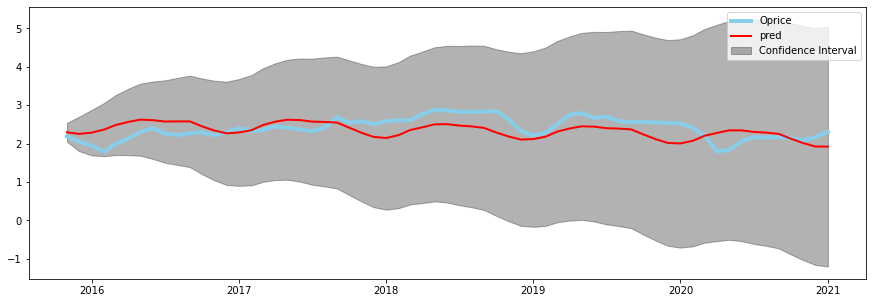

In [10]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson



model = SARIMAX(X_train['Oprice'], order=(2,1,2), seasonal_order=(2,1,2,12), trend='c') #Defining SARIMA model parameters   
model_fit = model.fit()
#df['forecast'] = model_fit.predict(exog =1,typ='levels')
print(model_fit.summary())
#print(model_fit.summary2())
print("Valoarea Durbin-Watson asociată modelului:",durbin_watson(model_fit.resid)) #Durbin-Watson

A = np.identity(len(model_fit.params))
A=A[1:,:]
Fvalue = model_fit.f_test(A) #F test
print("The F test value: ",Fvalue)

ax = pyplot.subplots(figsize=(15, 5))
fcast = model_fit.get_forecast(steps = 70).summary_frame() # Generating point prediction and confidence interval values for each prediction
X_test['pred'] = fcast['mean']
X_test['lower'] = fcast['mean_ci_lower']
X_test['upper'] = fcast['mean_ci_upper']




#print(X_test)
#pyplot.plot( 'DATE', "Oprice", data=X_train, marker='', markerfacecolor='green', markersize=10, color='green', linewidth=4)
pyplot.plot( 'DATE', "Oprice", data=X_test, marker='', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=4)
pyplot.plot( 'DATE', 'pred', data=X_test, marker='', color='red', linewidth=2)
pyplot.fill_between(X_test['DATE'],X_test['upper'], X_test['lower'], color='k', alpha=0.3, label = 'Confidence Interval')


# Show legend
pyplot.legend()

# Show chart
pyplot.show()




We see that as per the SARIMA model's output, the model's only relevant components are those of the mobile average: ma.L1, ma.L2, ar.S.L24 and $sigma^2$, with all this being said, the Ljung-Box has a p-value of 0.82, which means that the null hypothesis is true and the data is not white noise, thus it can be modeled. <br>
The Durbin-Watson test has a value of 1.78, slightly better than the previous model, likewise showing a sligh positive autocorrelation. The F-test value shows that the model is valid. <br>
After predicting the first 63 months, just like with the previous model, only the first 8 months are relevant, the others can be considered redundant. <br>
The last aspect worth noting is that of the informational criteria, all 3 of them being closer to 0 than the previous model, thus indicating that this model is superior.

In [11]:
#print(X_test)
forecast_accuracy(X_test['pred'], X_test['Oprice'])

Residuals = []
for index, row in X_test.iterrows():
    Residuals.append(row['pred']-row['Oprice'])
    
Reziduals = pd.Series(Residuals, name = "Residuals")

MAPE: 0.1143223780124149 
 ME: -0.0596707869525169 
 MAE: 0.27191837222107784 
 MPE: -0.012914591071793095 
 RMSE: 0.30887121873470197


We can see that the MAPE value is 0.12%, which means that the average prediction error is around 0.11% of the real values. <br>
The RMSE value shows that the mean difference between the prediction and the actual value is around 33 cents.

<h3> Next we shall cointegrate this time series with that of the price per crude barrel of oil <em>COprice</em>. We will run the <em> 2 Step Augmented Engle-Granger Cointegration Test </em> in order to verify if the 2 series are indeed cointegrated.

In [12]:
from statsmodels.tsa.stattools import coint
#print(X_train)
path = "\Data\CrudeOil.csv" #input path to data
df = pd.read_csv(path)
df["COprice"] = pd.to_numeric(df.COprice, errors = 'coerce')
df["DATE"] = pd.to_datetime(df['DATE'])
X_train2, X_test2 = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)
X_train['COprice'] = X_train2['COprice']
X_train = X_train.dropna()
#print(X_train)
print("The results of the 2 Step Engle-Granger Cointegration Test are: ",coint(X_train['COprice'],X_train['Oprice']))

The results of the 2 Step Engle-Granger Cointegration Test are:  (-6.881393079454767, 1.6393347031967812e-08, array([-3.94096428, -3.3607786 , -3.0615268 ]))


The 2 Step Engle-Granger Coint. Test shows a p-value of 1.63E-08, value lower than 0.05, thus indicating the acceptance of the H1 hypothesis, which states that the 2 time series are indeed cointegrated.

<h3> Next we will use the Johansen cointegration test

In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
jres = coint_johansen(X_train[['COprice','Oprice']], det_order=1, k_ar_diff = 1)
print(jres.meth)
print('Johansen test Eigenvalues: \n ')
print(' r<=0            r<=1')
print(jres.lr2, '\n')
print('Critical Eigenvalues: Crit 90% Crit 95% crit 99%: \n')
print(jres.max_eig_stat_crit_vals)


johansen
Johansen test Eigenvalues: 
 
 r<=0            r<=1
[56.12589657  5.98768434] 

Critical Eigenvalues: Crit 90% Crit 95% crit 99%: 

[[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]


Deoarece valorile calculate sunt mai mari față de valorile critice, se respinge ipoteza nulă a testului Johansen, prin urmare acceptăm ipoteza alternativă conform căreia seriile se cointegrează.

<h3> In order to be able to use ECM (Error Correction Model), an OLS model between the 1st degree diff. of the 2 series is necessary in order to obtain the errors needed for ECM </h3>

In [14]:
import statsmodels.formula.api as smf
#X_train_diff = (X_train).diff().dropna()
results = smf.ols(formula='COprice ~ Oprice',data = X_train).fit(cov_type='HC0')
print(results.summary())
print(results.params)
X_train['residual'] = results.resid
X_train['residual'] = X_train.residual.shift(1)

                            OLS Regression Results                            
Dep. Variable:                COprice   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     8228.
Date:                Mon, 16 Aug 2021   Prob (F-statistic):          3.37e-192
Time:                        11:36:27   Log-Likelihood:                -787.71
No. Observations:                 250   AIC:                             1579.
Df Residuals:                     248   BIC:                             1586.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.4331      0.656    -38.772      0.0

In [15]:
import statsmodels.api as sm
X_train_diff = X_train.copy()
X_train_diff= X_train_diff.diff()
X_train_diff=X_train_diff.dropna()
x = np.array(X_train_diff[['COprice','residual']])
x = sm.add_constant(x)
y = np.array(X_train_diff['Oprice'])
ECM = sm.OLS(endog=y, exog=x).fit(cov_type='HC0')
print(ECM.summary(xname=['Constantă','COprice','Reziduri']))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     54.58
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           2.49e-20
Time:                        11:36:27   Log-Likelihood:                 214.19
No. Observations:                 248   AIC:                            -422.4
Df Residuals:                     245   BIC:                            -411.8
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constantă      0.0020      0.007      0.305      0.7

ECM has an $R^2$ value of 0.545 which shows that about 55% of the fuel price variation can be explained by the model. <br>
The value of Prob (F-statistic) shows that the model is statistically valid, as it is lower than 0.05 <br>
The Durbin-Watson Test's value is 1.767, close to 2 and showing an insignifiant amount of autocorrelation.

In [16]:
from scipy import stats
def conf_interval_limits(prediction, y_test, test_predictions, pi=.95):
    '''
    Generates a confidence interval for predictions.

    INPUT:

    - point predictions,

    - y_test

    - all predictions,

    - confidence level (default is 0.95)

    OUTPUT:

    - confidence interval for the point prediction
    '''

    #abaterea standard al lui y_test

    sum_errs = np.sum((y_test - test_predictions)**2)

    stdev = np.sqrt(1/(len(y_test)-2)* sum_errs)

    #calculează intervalul pe bază abaterii standard

    one_minus_pi = 1 - pi

    ppf_lookup = 1 - (one_minus_pi/2)

    z_score = stats.norm.ppf(ppf_lookup)

    interval = z_score * stdev

    #generează limita inferioară și limita superioară

    lower, upper = prediction - interval, prediction + interval

    return lower, prediction, upper

def conf_interval(y_pred,Original,date):

    lower_vet = []

    upper_vet = []

    for i in y_pred:

            lower, predicition, upper = conf_interval_limits(i, Original, y_pred)

            lower_vet.append(lower)

            upper_vet.append(upper)
    
    X_test['pred'] = y_pred
    X_test['lower'] = lower_vet
    X_test['upper'] = upper_vet

    pyplot.figure(figsize = (12,5))
    pyplot.xlabel('Year')
    pyplot.plot( 'DATE', "Oprice", data=X_test, marker='', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=4)
    pyplot.plot( 'DATE', 'pred', data=X_test, marker='', color='red', linewidth=2)
    pyplot.fill_between(X_test['DATE'],X_test['upper'], X_test['lower'], color='k', alpha=0.3, label = 'confidence interval')




    pyplot.ylabel('retail fuel price')
    pyplot.title("predicted vs. real")
    pyplot.legend()
    pyplot.ylim(-10,10)
    pyplot.show()

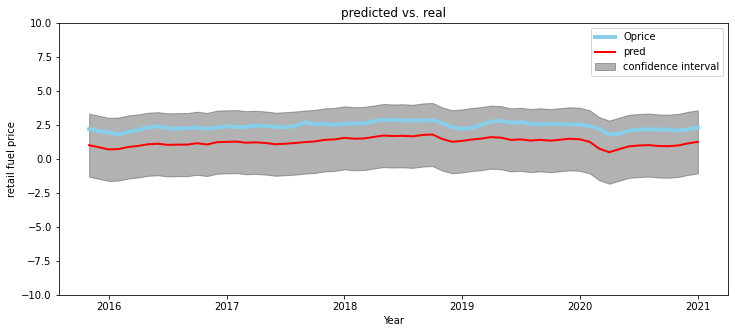

In [17]:

X_test['COprice'] = X_test2.COprice
x = np.array(X_test.COprice)
x = sm.add_constant(x)
results2 = sm.OLS(endog=X_test.Oprice, exog=x).fit(cov_type='HC0') # we obtain the residuals of the predicted time interval


X_test['residual'] = results2.resid
X_test['Constant'] = 1

#X_test['residual'] = X_train.residual.shift(1)
#X_test = X_test.drop(['pred','lower','upper'], axis=1)
previziune = ECM.predict(X_test[['Constant','COprice','residual']]) #inputing the independent variables coresponding to the predicted time period
#print(previziune)
conf_interval(previziune,X_test.Oprice,X_test.DATE)


<h3> Chart of the ECM predictions compared to the testing subset.

<h3> Checking by using the Granger Test of Causality if the price for a barrel of oil <em>causes</em> the mean retail price of fuel. </h3>

In [18]:
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(X_train_diff[['COprice','Oprice']], maxlag=15, addconst=True, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4649  , p=0.0202  , df_denom=244, df_num=1
ssr based chi2 test:   chi2=5.5321  , p=0.0187  , df=1
likelihood ratio test: chi2=5.4710  , p=0.0193  , df=1
parameter F test:         F=5.4649  , p=0.0202  , df_denom=244, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.6319  , p=0.0041  , df_denom=241, df_num=2
ssr based chi2 test:   chi2=11.4976 , p=0.0032  , df=2
likelihood ratio test: chi2=11.2370 , p=0.0036  , df=2
parameter F test:         F=5.6319  , p=0.0041  , df_denom=241, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4019  , p=0.0184  , df_denom=238, df_num=3
ssr based chi2 test:   chi2=10.5058 , p=0.0147  , df=3
likelihood ratio test: chi2=10.2868 , p=0.0163  , df=3
parameter F test:         F=3.4019  , p=0.0184  , df_denom=238, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6285  , p=0.0352  

The p-values of the 4 tests pertaining to the Granger Causality are 0, lower than 0.05, thus leading to the acceptance of the H1 hypothesis for each of them. This hypothesis states that the previous values of the 2nd variable (price of a barrel of crude oil) has a significant statistical impact on the value of the first variable (retail price of fuel).

In [19]:
from statsmodels.tsa.api import VAR
X_dff = X_train_diff[['COprice','Oprice']]
model = VAR(endog=X_dff)
res = model.select_order(30)
res.summary()

Q:\Python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


,AIC,BIC,FPE,HQIC
0,-1.145,-1.114,0.3183,-1.132
1,-1.627,-1.534,0.1964,-1.590
2,-1.700,-1.545*,0.1826,-1.638*
3,-1.691,-1.474,0.1844,-1.603
4,-1.668,-1.389,0.1886,-1.555
5,-1.698,-1.357,0.1831,-1.560
6,-1.703,-1.300,0.1821,-1.540
7,-1.805,-1.339,0.1645,-1.617
8,-1.811,-1.283,0.1636,-1.598
9,-1.866,-1.276,0.1549,-1.627


We select the 14th lag to be used in the modeling of VAR, as it has the lowest AIC values.

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 16, Aug, 2021
Time:                     11:36:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.21625
Nobs:                     234.000    HQIC:                  -1.72738
Log likelihood:          -363.557    FPE:                   0.126168
AIC:                     -2.07270    Det(Omega_mle):       0.0998781
--------------------------------------------------------------------
Results for equation COprice
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.152410         0.271538            0.561           0.575
L1.COprice          0.608045         0.091103            6.674           0.000
L1.Oprice         -16.288173         3.579899           -4.550    

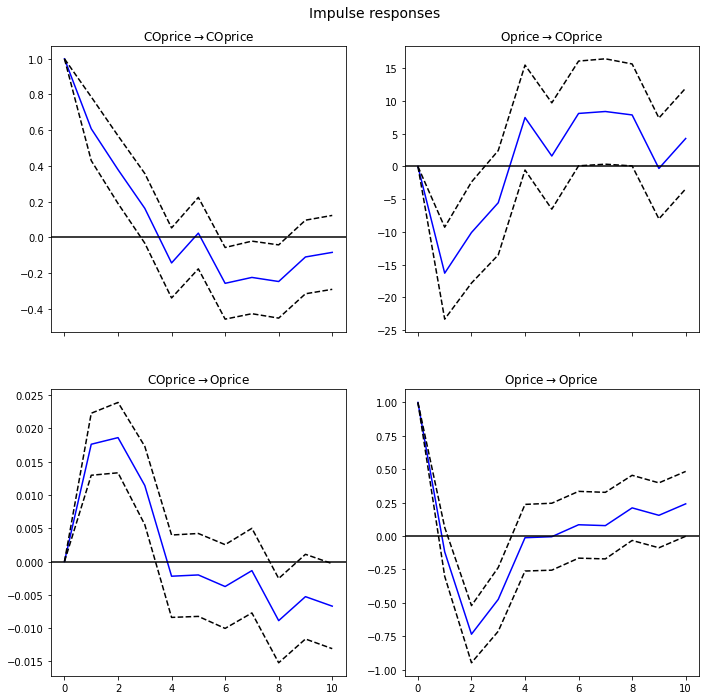

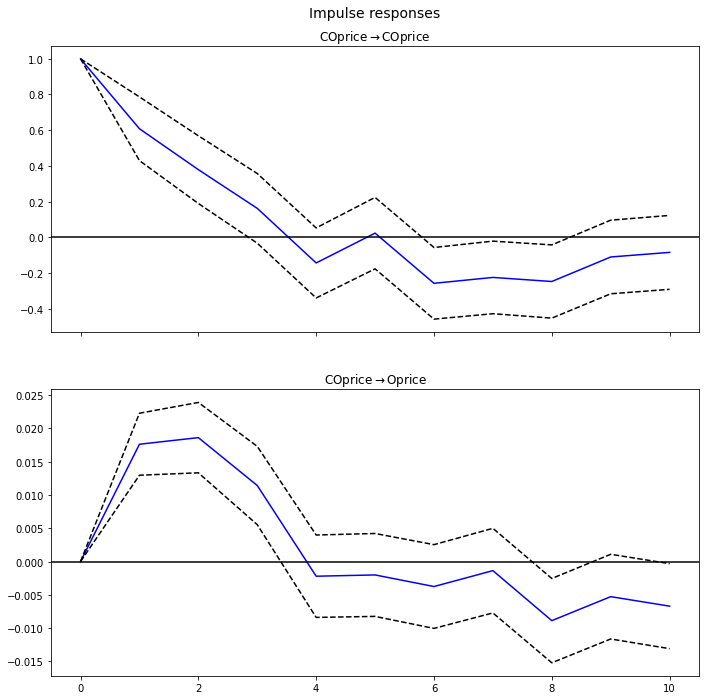

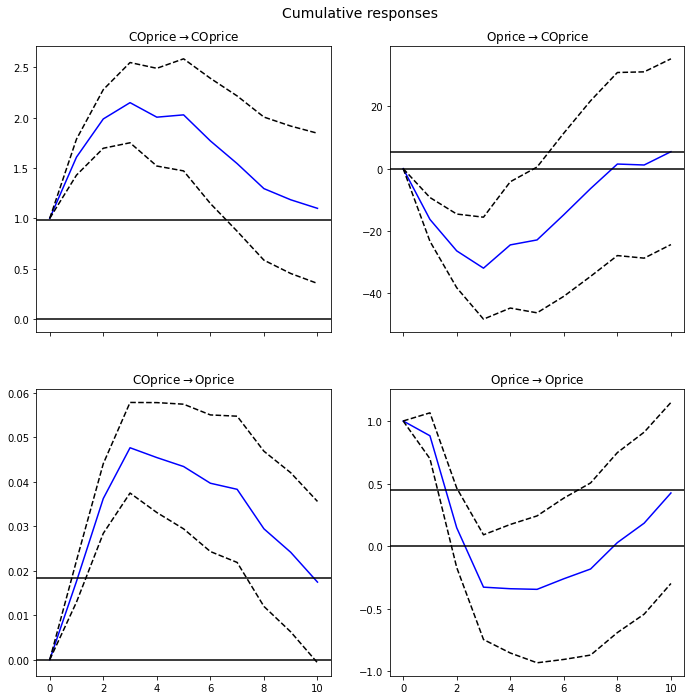

In [20]:
#Modeling the VAR
#print(X_dff)
model_fit = model.fit(maxlags=15, ic = 'aic')
irf = model_fit.irf(10)
irf.plot(orth=False) #non-ortogonal IFR
irf.plot(impulse='COprice') #IFR with the independent variable
irf.plot_cum_effects(orth=False) #IFR with cumulative effects

#Displaying the VAR results
print(model_fit.summary())
out = durbin_watson(model_fit.resid)
print(" Durbin-Watson for COprice and Oprice: ",out)

We take from the correlation matrix of the residuals that the link between the price for a barrel of crude oil and the retail price of fuel is a strong one. <br>
We can also take a look at the IFR charts in order to obtain a better outlook on the relationship between the 2 variables.

<h3> Using the VAR model, we predict the 2 variables

In [21]:

X_test_fin = X_test2
X_test_fin['Oprice'] = X_test['Oprice']
X_test_fin =X_test_fin.drop(['DATE'],axis=1)
#print(X_test_fin)
# Obtaining the best lag number
lag_order = model_fit.k_ar
print("The best lag to use for VAR is: ",lag_order)
# Data to be used in prediction
input_data = X_dff.values[-lag_order:]
#print(input_data)
# Predicting the data
pred = model_fit.forecast(y=input_data, steps=63)
pred = (pd.DataFrame(pred, index=X_test_fin.index, columns=X_test_fin.columns + '_pred'))
#print(pred)

The best lag to use for VAR is:  14


<h3> We invert the values in order to attain a level of comparability between the VAR predictions and the historical values

In [22]:
def invert_transformation(X_train, pred_df):
    forecast = pred.copy()
    columns = {'Oprice','COprice'}
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col) +'_pred'].cumsum()
    return forecast
  

output = invert_transformation(X_train, pred)
#print(output)
output_original = np.exp(output) #calculating the exponents for each element
#print(output_original)

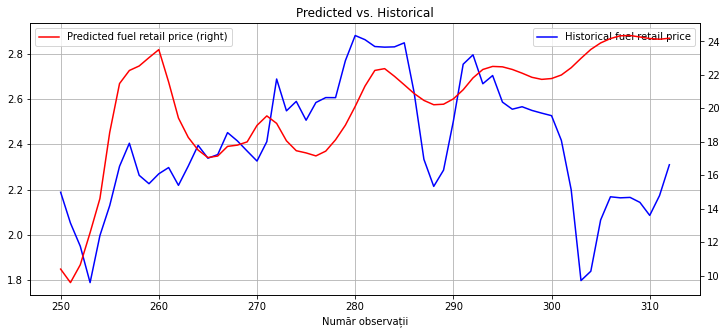

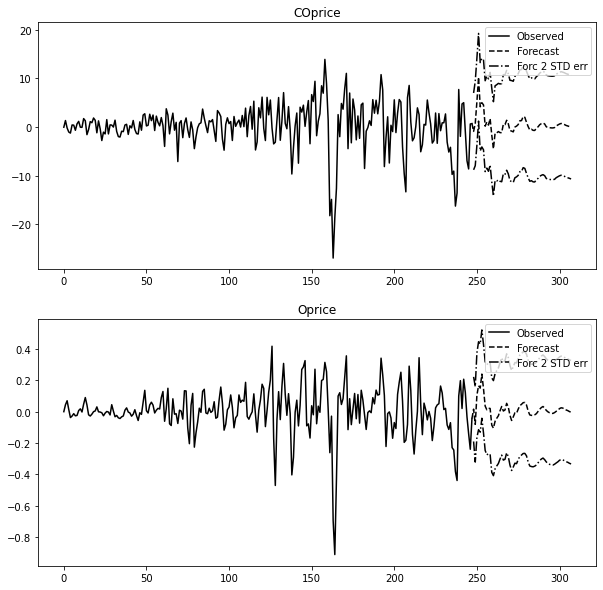

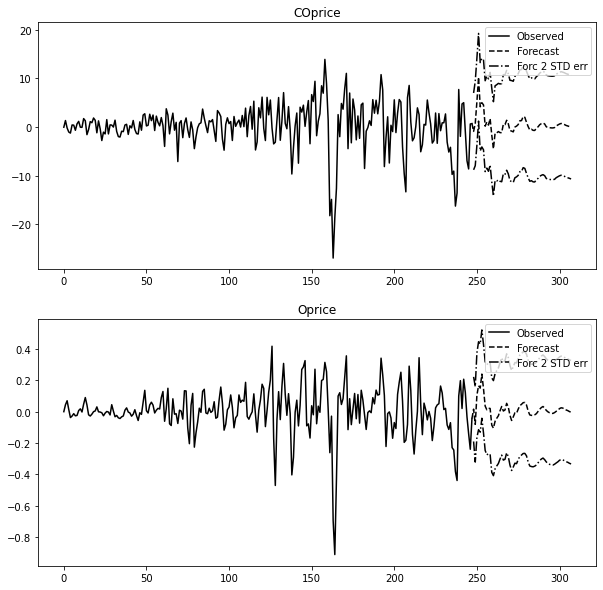

In [23]:
pyplot.figure(figsize = (12,5))
pyplot.xlabel('Număr observații')

ax1 = X_test.Oprice.plot(color='Blue', grid = True, label = 'Historical fuel retail price')
ax2 = output_original.Oprice_pred.plot(color = 'red', grid = True, secondary_y = True, label = "Predicted fuel retail price")

ax1.legend(loc=1)
ax2.legend(loc=2)
pyplot.title('Predicted vs. Historical')
pyplot.show()
model_fit.plot_forecast(60)

We can see that this model isn't ideal, failing from the very first lag and losing most predictive power starting with the 8th one.

In [24]:

mae = np.mean(np.abs(output_original['Oprice_pred'] - X_test['Oprice']))
print('MAE: %f' % mae)
rmse = np.mean((output_original['Oprice_pred'] - X_test['Oprice'])**2)**.5
print('RMSE: %f' % rmse)

MAE: 17.794409
RMSE: 18.107890


<h3> Next we will use the <em> Vector Error Correction Model</em> and recheck the Johansen Cointegration Test </h3>

Testul Johansen indică faptul că ambele variabile se cointegrează

In [25]:
import statsmodels.tsa.vector_ar.vecm as vecm
X_train = X_train[['Oprice','COprice']]
vec_rank1 = vecm.select_coint_rank(X_train, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.05)
print(vec_rank1.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          56.13          17.15
  1   2          5.988          3.841
-------------------------------------


Applying the VECM model on the first 63 observations, even though only the first 8 have any significant prediction power.

In [26]:
from statsmodels.tsa.vector_ar.vecm import VECM

vecm = VECM(endog = X_train, k_ar_diff = 14, coint_rank = 2, deterministic = 'ci')
vecm_fit = vecm.fit()
print(vecm_fit.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation Oprice
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Oprice      -0.0753      0.114     -0.659      0.510      -0.299       0.149
L1.COprice      0.0165      0.003      5.484      0.000       0.011       0.022
L2.Oprice      -0.4173      0.123     -3.400      0.001      -0.658      -0.177
L2.COprice      0.0089      0.003      2.786      0.005       0.003       0.015
L3.Oprice      -0.2344      0.126     -1.860      0.063      -0.482       0.013
L3.COprice      0.0080      0.003      2.442      0.015       0.002       0.014
L4.Oprice      -0.0577      0.124     -0.463      0.643      -0.302       0.186
L4.COprice     -0.0004      0.003     -0.119      0.905      -0.007       0.006
L5.Oprice      -0.3797      0.125     -3.044      0.002      -0.624      -0.135
L5.COprice      0.0062      0.003 

Determining the limits of the confidence interval for the time series

In [27]:
forecast, lower, upper = vecm_fit.predict(63, 0.05)
'''print('lower limits of the CI: ')
print(lower.round(2))
print('\npoint prediction: ')
print(forecast.round(2))
print('\nupper limits of the CI: ')
print(upper.round(2))'''
x = pd.DataFrame(forecast.round(2), columns = ['Opred ', 'Forecast_CO'])
#print(x.dtypes)

Observam pe baza graficului faptul că acest model este întradevăr eficient pentru 8 observații, previzionând valori aproape de realiate.

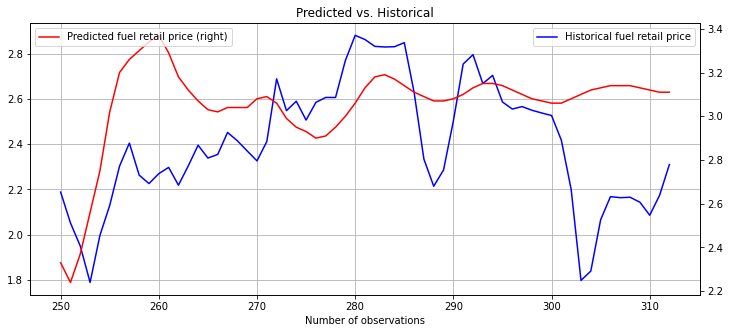

In [28]:
pyplot.figure(figsize = (12,5))
pyplot.xlabel('Number of observations')
x.index=X_test_fin.index



ax1 = X_test_fin.Oprice.plot(color='Blue', grid = True, label = 'Historical fuel retail price')
ax2 = x.iloc[:,0].plot(color = 'red', grid = True, secondary_y = True, label = "Predicted fuel retail price")

ax1.legend(loc=1)
ax2.legend(loc=2)
pyplot.title('Predicted vs. Historical')
pyplot.show()

Lastly we shall draw the graph of the VECM retail fuel price prediction along with the prediction interval

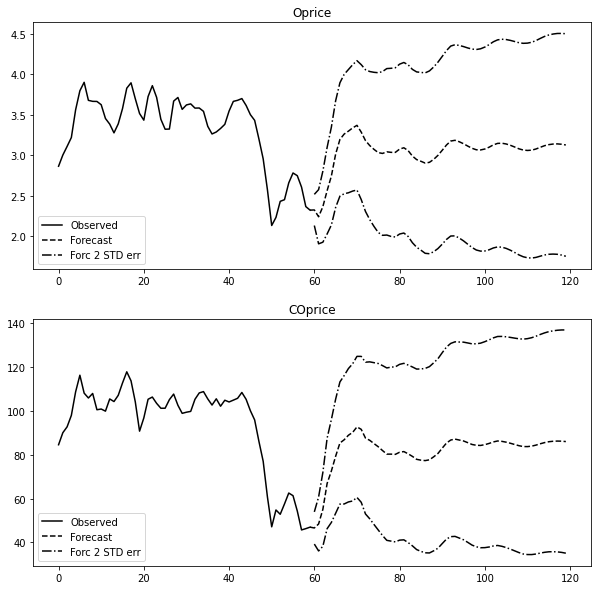

In [29]:
vecm_fit.plot_forecast(steps=60, n_last_obs=60)